In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
customers = pd.read_csv('Customers_Zeotap.csv')
transactions = pd.read_csv('Transactions_Zeotap.csv')
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

# Here i have merged aggregated transaction data with customer profile
customer_data = customers.merge(customer_transactions, on='CustomerID', how='left').fillna(0)


In [4]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
region_encoded = encoder.fit_transform(customer_data[['Region']])
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))
features = pd.concat([customer_data[['TotalValue', 'Quantity']], region_encoded_df], axis=1)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [5]:
db_scores = []
silhouette_scores = []
clusters_range = range(2, 11)

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(features_scaled, labels)
    silhouette_avg = silhouette_score(features_scaled, labels)

    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

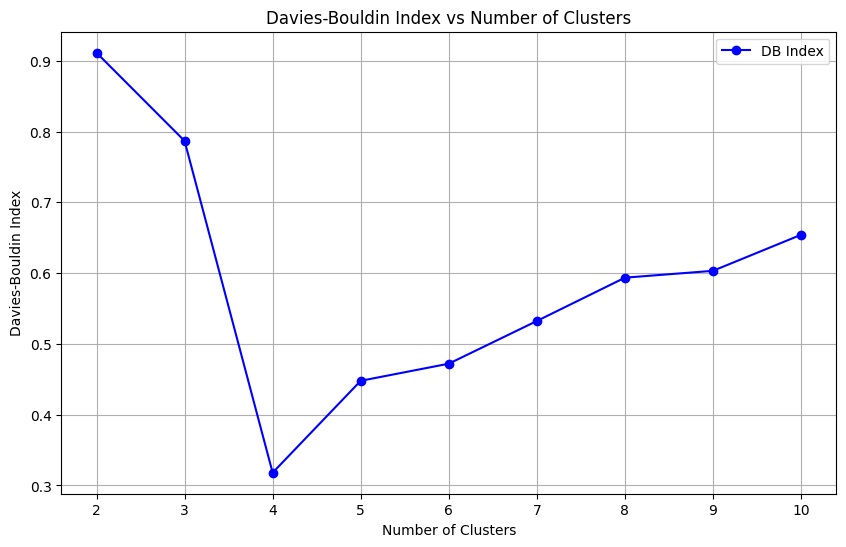

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, db_scores, marker='o', linestyle='-', color='b', label='DB Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.grid()
plt.show()


Optimal number of clusters: 4


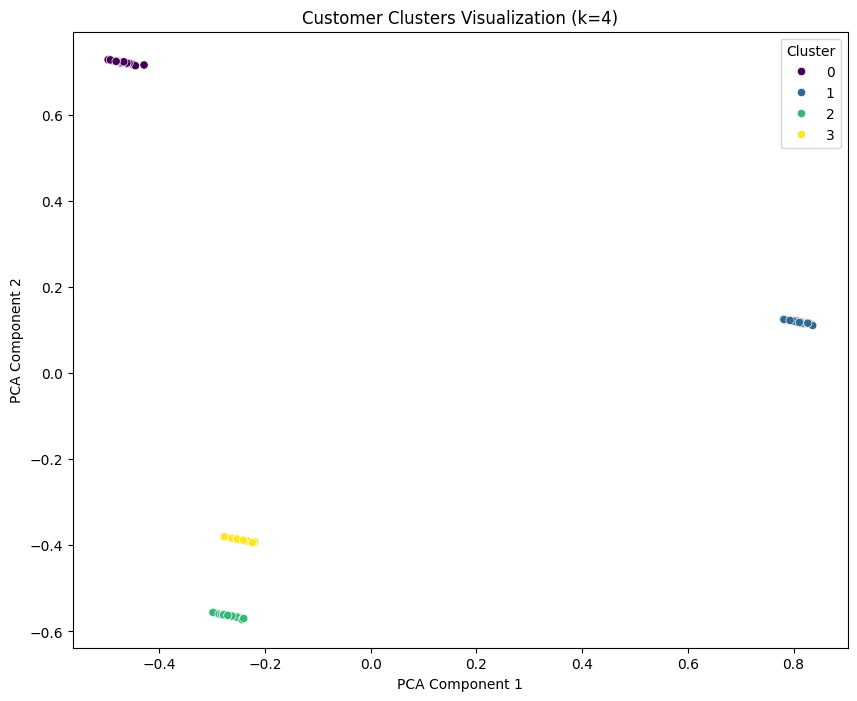

In [7]:
optimal_k = clusters_range[db_scores.index(min(db_scores))]
print(f"Optimal number of clusters: {optimal_k}")

# kmeans algorithm used
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(features_scaled)
customer_data['Cluster'] = kmeans.labels_

# visualization IS DONE USING PCA ans sns
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=customer_data['Cluster'],
    palette='viridis',
    legend='full'
)
plt.title(f'Customer Clusters Visualization (k={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


4 clusters are used



In [8]:
# This step isn't necessary, i've done this for my clarification
customer_data[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)
print("Customer clusters saved to 'Customer_Clusters.csv'")

Customer clusters saved to 'Customer_Clusters.csv'
